<a href="https://colab.research.google.com/github/rlaaudrb1104/Ai/blob/PJH/GraphCodeBERT_dacon2__random.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os
import random
from itertools import combinations, product
import re
import sklearn
from sklearn.model_selection import train_test_split
import torch
torch.set_float32_matmul_precision('high')
from torch.utils.data import Dataset, DataLoader
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Seed 고정 함수
def seed_everything(seed: int = 42, contain_cuda: bool = False):
  os.environ['PYTHONHASHSEED'] = str(seed)
  random.seed(seed)
  np.random.seed(seed)

  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  print(f"Seed set as {seed}")

seed = 42
seed_everything(seed)

Seed set as 42


In [3]:
# CUDA 사용 가능 여부 확인 및 GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
def preprocess_and_remove_extras(filepath):
    with open(filepath, 'r', encoding='utf-8') as file:
        content = file.read()

    content = re.sub(re.compile("/\*.*?\*/", re.DOTALL), "", content) # 멀티 라인 주석 제거
    content = re.sub(re.compile("//.*?\n"), "", content) # 싱글 라인 주석 제거
    content = re.sub(re.compile("#include <.*?>\n"), "", content) # angle brackets를 사용하는 include 제거
    content = re.sub(re.compile("#include \".*?\"\n"), "", content) # double quotes를 사용하는 include 제거
    content = re.sub(re.compile("#define .*?\n"), "", content) # 매크로 정의 제거
    content = re.sub(re.compile("[\t ]+"), " ", content) # 공백 및 탭 정리
    content = re.sub(re.compile("\n\s*\n"), "\n", content)# 여러 줄바꿈을 하나로

    # 공백이 아닌 줄만 선택하여 리스트로 만든 후, 문자열로 결합
    processed_script = '\n'.join([line.strip() for line in content.splitlines() if line.strip()])

    return processed_script

In [5]:
#  전처리 적용
#  이미 create_train_data 만들 때 적용했지만, test.csv와, sample_train.csv에도 같은 전처리를 하기 위해 다시 정의
def remove_extras(code):
    code = re.sub(re.compile("/\*.*?\*/", re.DOTALL), "", code) # 멀티 라인 주석 제거
    code = re.sub(re.compile("//.*?\n"), "", code) # 싱글 라인 주석 제거
    code = re.sub(re.compile("#include <.*?>\n"), "", code)  # angle brackets를 사용하는 include 제거
    code = re.sub(re.compile("#include \".*?\"\n"), "", code)  # double quotes를 사용하는 include 제거
    code = re.sub(re.compile("#define .*?\n"), "", code)  # 매크로 정의 제거
    code = re.sub(re.compile("[\t ]+"), " ", code)  # 탭과 여러 공백을 하나의 공백으로
    code = re.sub(re.compile("\n\s*\n"), "\n", code)  # 여러 줄바꿈을 하나로

    return code.strip()

In [6]:
class CodeDataset(Dataset):
    def __init__(self, tokenizer, data, max_length=512, include_labels=True):
        self.tokenizer = tokenizer
        self.data = data
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        code = remove_extras(self.data.iloc[idx]['code'])  # 특정 인덱스의 코드를 가져와 추가 요소를 제거합니다.

        inputs = self.tokenizer(
            code,
            padding='max_length', truncation=True, max_length=self.max_length, return_tensors="pt"
        )
        inputs = {key: val.squeeze() for key, val in inputs.items()}

        label = torch.tensor(self.data.iloc[idx]['labels'], dtype=torch.long)  # 해당 코드의 정답 라벨을 가져옵니다.
        inputs['labels'] = label

        return inputs

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
filepath_train = '/content/drive/MyDrive/final_train5.csv'
filepath_val = '/content/drive/MyDrive/final_val2.csv'
train_df = pd.read_csv(filepath_train)
val_df = pd.read_csv(filepath_val)

In [9]:
train_df = train_df.drop(columns=['Unnamed: 0'])
val_df = val_df.drop(columns=['Unnamed: 0'])
train_df = train_df.drop(columns=['vul'])
val_df = val_df.drop(columns=['vul'])

In [10]:
# GraphCodeBERT 모델 및 토크나이저 로드
model_name = "microsoft/graphcodebert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.truncation_side = "left"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=11).to(device)

# 훈련 세트와 검증 세트에 대한 데이터셋 생성
train_dataset = CodeDataset(tokenizer, train_df, max_length=512)
val_dataset = CodeDataset(tokenizer, val_df, max_length=512, include_labels=True)

# 데이터 로더 준비
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# 파인 튜닝을 위한 옵티마이저 설정
optimizer = AdamW(model.parameters(), lr=2e-5)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/539 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 206/206 [00:39<00:00,  5.26it/s]


Fold 1, Epoch 1, Training Loss: 0.8494475497250876, Train F1 Score: 0.7062850391256588, Validation Loss: 0.5825486937040482, Validation F1 Score: 0.7883649124308776
Classification Report:
              precision    recall  f1-score   support

           0     0.9048    0.8702    0.8872       601
           1     0.5501    0.8100    0.6552       400
           2     0.8549    0.9947    0.9195       379
           3     0.9448    0.8228    0.8796       333
           4     0.8456    0.9543    0.8966       350
           5     0.9823    0.9327    0.9568       297
           6     0.3955    0.5212    0.4497       236
           7     0.9741    0.8210    0.8910       229
           8     0.9796    0.5549    0.7085       173
           9     0.7674    0.2102    0.3300       157
          10     0.8197    0.3968    0.5348       126

    accuracy                         0.7921      3281
   macro avg     0.8199    0.7172    0.7372      3281
weighted avg     0.8229    0.7921    0.7884      3281


100%|██████████| 206/206 [00:39<00:00,  5.27it/s]


Fold 1, Epoch 2, Training Loss: 0.4711221496301998, Train F1 Score: 0.8297271307442137, Validation Loss: 0.4956043277713425, Validation F1 Score: 0.8256538906830188
Classification Report:
              precision    recall  f1-score   support

           0     0.8406    0.8952    0.8670       601
           1     0.6820    0.7775    0.7266       400
           2     0.8549    0.9947    0.9195       379
           3     0.8680    0.8889    0.8783       333
           4     0.8902    0.8571    0.8734       350
           5     0.9720    0.9360    0.9537       297
           6     0.7191    0.5424    0.6184       236
           7     0.9785    0.7948    0.8771       229
           8     0.8592    0.7052    0.7746       173
           9     0.6727    0.7070    0.6894       157
          10     0.6697    0.5794    0.6213       126

    accuracy                         0.8278      3281
   macro avg     0.8188    0.7889    0.7999      3281
weighted avg     0.8302    0.8278    0.8257      3281


100%|██████████| 206/206 [00:39<00:00,  5.27it/s]


Fold 1, Epoch 3, Training Loss: 0.3327229736440974, Train F1 Score: 0.881946492728307, Validation Loss: 0.4870942801020099, Validation F1 Score: 0.8419484325904157
Classification Report:
              precision    recall  f1-score   support

           0     0.9541    0.8652    0.9075       601
           1     0.6393    0.8775    0.7397       400
           2     0.8549    0.9947    0.9195       379
           3     0.9392    0.8348    0.8839       333
           4     0.8434    0.9543    0.8954       350
           5     0.9717    0.9259    0.9483       297
           6     0.6725    0.6525    0.6624       236
           7     0.9757    0.8777    0.9241       229
           8     0.9098    0.6994    0.7908       173
           9     0.7385    0.6115    0.6690       157
          10     0.7945    0.4603    0.5829       126

    accuracy                         0.8427      3281
   macro avg     0.8449    0.7958    0.8112      3281
weighted avg     0.8550    0.8427    0.8419      3281



100%|██████████| 206/206 [00:39<00:00,  5.28it/s]


Fold 1, Epoch 4, Training Loss: 0.23869487702585301, Train F1 Score: 0.9120698271191369, Validation Loss: 0.45558194863865403, Validation F1 Score: 0.8513424728234986
Classification Report:
              precision    recall  f1-score   support

           0     0.9203    0.8835    0.9015       601
           1     0.7211    0.8275    0.7707       400
           2     0.8549    0.9947    0.9195       379
           3     0.8434    0.9219    0.8809       333
           4     0.9204    0.8257    0.8705       350
           5     0.9724    0.9495    0.9608       297
           6     0.7215    0.6695    0.6945       236
           7     0.9948    0.8428    0.9125       229
           8     0.9172    0.7688    0.8365       173
           9     0.6974    0.6752    0.6861       157
          10     0.6825    0.6825    0.6825       126

    accuracy                         0.8513      3281
   macro avg     0.8405    0.8220    0.8287      3281
weighted avg     0.8563    0.8513    0.8513      328

100%|██████████| 206/206 [00:39<00:00,  5.27it/s]


Fold 1, Epoch 5, Training Loss: 0.18657157706528357, Train F1 Score: 0.9298630493915436, Validation Loss: 0.4654074679857834, Validation F1 Score: 0.8600159448253785
Classification Report:
              precision    recall  f1-score   support

           0     0.9350    0.8852    0.9094       601
           1     0.7829    0.8025    0.7926       400
           2     0.8549    0.9947    0.9195       379
           3     0.8407    0.9189    0.8780       333
           4     0.9099    0.8371    0.8720       350
           5     0.9856    0.9226    0.9530       297
           6     0.7634    0.7246    0.7435       236
           7     0.9756    0.8734    0.9217       229
           8     0.8305    0.8497    0.8400       173
           9     0.6556    0.7516    0.7003       157
          10     0.7387    0.6508    0.6920       126

    accuracy                         0.8598      3281
   macro avg     0.8430    0.8374    0.8384      3281
weighted avg     0.8636    0.8598    0.8600      3281

100%|██████████| 206/206 [00:39<00:00,  5.27it/s]


Fold 1, Epoch 6, Training Loss: 0.16206603715900422, Train F1 Score: 0.937165840150146, Validation Loss: 0.479943415844865, Validation F1 Score: 0.8599336896275892
Classification Report:
              precision    recall  f1-score   support

           0     0.8954    0.9118    0.9035       601
           1     0.7558    0.8200    0.7866       400
           2     0.8529    0.9947    0.9184       379
           3     0.8750    0.8829    0.8789       333
           4     0.9099    0.8371    0.8720       350
           5     0.9823    0.9327    0.9568       297
           6     0.7674    0.6992    0.7317       236
           7     0.9398    0.8865    0.9124       229
           8     0.9301    0.7688    0.8418       173
           9     0.7312    0.7452    0.7382       157
          10     0.7395    0.6984    0.7184       126

    accuracy                         0.8604      3281
   macro avg     0.8527    0.8343    0.8417      3281
weighted avg     0.8627    0.8604    0.8599      3281



100%|██████████| 206/206 [00:39<00:00,  5.27it/s]


Fold 1, Epoch 7, Training Loss: 0.13976866281534567, Train F1 Score: 0.9416131657176571, Validation Loss: 0.5591911187039991, Validation F1 Score: 0.8507877696233724
Classification Report:
              precision    recall  f1-score   support

           0     0.9577    0.8669    0.9100       601
           1     0.7794    0.7775    0.7785       400
           2     0.8510    0.9947    0.9173       379
           3     0.8555    0.8889    0.8719       333
           4     0.8824    0.8571    0.8696       350
           5     0.9721    0.9394    0.9555       297
           6     0.7524    0.6695    0.7085       236
           7     0.9755    0.8690    0.9192       229
           8     0.8980    0.7630    0.8250       173
           9     0.5369    0.8344    0.6534       157
          10     0.6923    0.6429    0.6667       126

    accuracy                         0.8488      3281
   macro avg     0.8321    0.8276    0.8250      3281
weighted avg     0.8595    0.8488    0.8508      3281

100%|██████████| 206/206 [00:39<00:00,  5.27it/s]


Fold 1, Epoch 8, Training Loss: 0.13478146921786502, Train F1 Score: 0.9454087669701043, Validation Loss: 0.5114318522007557, Validation F1 Score: 0.8613763163371607
Classification Report:
              precision    recall  f1-score   support

           0     0.9586    0.8869    0.9213       601
           1     0.7443    0.8225    0.7815       400
           2     0.8529    0.9947    0.9184       379
           3     0.8709    0.8709    0.8709       333
           4     0.9468    0.8143    0.8756       350
           5     0.9073    0.9562    0.9311       297
           6     0.7240    0.7669    0.7449       236
           7     0.9757    0.8777    0.9241       229
           8     0.9627    0.7457    0.8404       173
           9     0.6789    0.8217    0.7435       157
          10     0.7456    0.6746    0.7083       126

    accuracy                         0.8604      3281
   macro avg     0.8516    0.8393    0.8418      3281
weighted avg     0.8685    0.8604    0.8614      3281

100%|██████████| 206/206 [00:39<00:00,  5.25it/s]


Fold 1, Epoch 9, Training Loss: 0.1275360457448675, Train F1 Score: 0.9466902144760074, Validation Loss: 0.5546515698666747, Validation F1 Score: 0.8649728268776405
Classification Report:
              precision    recall  f1-score   support

           0     0.9347    0.9052    0.9197       601
           1     0.7574    0.8350    0.7943       400
           2     0.8529    0.9947    0.9184       379
           3     0.9888    0.7988    0.8837       333
           4     0.8524    0.9571    0.9017       350
           5     0.9788    0.9327    0.9552       297
           6     0.6604    0.7500    0.7024       236
           7     0.9758    0.8821    0.9266       229
           8     0.8704    0.8150    0.8418       173
           9     0.7842    0.6943    0.7365       157
          10     0.8000    0.6032    0.6878       126

    accuracy                         0.8650      3281
   macro avg     0.8596    0.8335    0.8426      3281
weighted avg     0.8717    0.8650    0.8650      3281


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 205/205 [00:39<00:00,  5.25it/s]


Fold 2, Epoch 1, Training Loss: 0.8519133973728307, Train F1 Score: 0.7082612972164848, Validation Loss: 0.5459344179255934, Validation F1 Score: 0.8056450402051439
Classification Report:
              precision    recall  f1-score   support

           0     0.8429    0.9148    0.8774       575
           1     0.6976    0.6709    0.6840       471
           2     0.8832    0.9918    0.9344       366
           3     0.9431    0.8103    0.8717       348
           4     0.8711    0.9228    0.8963       337
           5     0.9518    0.9338    0.9427       317
           6     0.5337    0.4826    0.5068       230
           7     0.9415    0.8655    0.9019       223
           8     0.9310    0.6279    0.7500       172
           9     0.4106    0.5041    0.4526       123
          10     0.5172    0.6356    0.5703       118

    accuracy                         0.8058      3280
   macro avg     0.7749    0.7600    0.7625      3280
weighted avg     0.8123    0.8058    0.8056      3280


100%|██████████| 205/205 [00:38<00:00,  5.26it/s]


Fold 2, Epoch 2, Training Loss: 0.4591962486192421, Train F1 Score: 0.8404552919065931, Validation Loss: 0.44717678149435214, Validation F1 Score: 0.843055699564872
Classification Report:
              precision    recall  f1-score   support

           0     0.9072    0.9009    0.9040       575
           1     0.7326    0.8259    0.7764       471
           2     0.9647    0.8962    0.9292       366
           3     0.7500    0.9914    0.8540       348
           4     0.9791    0.8338    0.9006       337
           5     0.9522    0.9432    0.9477       317
           6     0.7418    0.5870    0.6553       230
           7     0.9474    0.8879    0.9167       223
           8     0.9912    0.6512    0.7860       172
           9     0.5500    0.6260    0.5856       123
          10     0.6090    0.6864    0.6454       118

    accuracy                         0.8424      3280
   macro avg     0.8296    0.8027    0.8092      3280
weighted avg     0.8550    0.8424    0.8431      3280


100%|██████████| 205/205 [00:38<00:00,  5.26it/s]


Fold 2, Epoch 3, Training Loss: 0.3255231510572721, Train F1 Score: 0.883174010636217, Validation Loss: 0.43445151470283544, Validation F1 Score: 0.8566372170746874
Classification Report:
              precision    recall  f1-score   support

           0     0.9619    0.8783    0.9182       575
           1     0.7732    0.7962    0.7845       471
           2     0.8835    0.9945    0.9357       366
           3     0.8837    0.9167    0.8999       348
           4     0.9481    0.8665    0.9054       337
           5     0.9210    0.9558    0.9381       317
           6     0.7500    0.6391    0.6901       230
           7     0.9756    0.8969    0.9346       223
           8     0.7421    0.8198    0.7790       172
           9     0.5200    0.7398    0.6107       123
          10     0.7447    0.5932    0.6604       118

    accuracy                         0.8558      3280
   macro avg     0.8276    0.8270    0.8233      3280
weighted avg     0.8625    0.8558    0.8566      3280


100%|██████████| 205/205 [00:38<00:00,  5.27it/s]


Fold 2, Epoch 4, Training Loss: 0.22735190511841086, Train F1 Score: 0.9155760937129688, Validation Loss: 0.4594534876029484, Validation F1 Score: 0.8519602727076416
Classification Report:
              precision    recall  f1-score   support

           0     0.8917    0.9165    0.9039       575
           1     0.7627    0.7643    0.7635       471
           2     0.8835    0.9945    0.9357       366
           3     0.8486    0.9339    0.8892       348
           4     0.9757    0.8338    0.8992       337
           5     0.9766    0.9211    0.9481       317
           6     0.6190    0.7913    0.6947       230
           7     0.9434    0.8969    0.9195       223
           8     0.9225    0.7616    0.8344       172
           9     0.7284    0.4797    0.5784       123
          10     0.7170    0.6441    0.6786       118

    accuracy                         0.8527      3280
   macro avg     0.8426    0.8125    0.8223      3280
weighted avg     0.8581    0.8527    0.8520      3280

100%|██████████| 205/205 [00:38<00:00,  5.26it/s]


Fold 2, Epoch 5, Training Loss: 0.17572569067833263, Train F1 Score: 0.93280473117629, Validation Loss: 0.4886361360510175, Validation F1 Score: 0.8542296105679048
Classification Report:
              precision    recall  f1-score   support

           0     0.9022    0.9148    0.9085       575
           1     0.7960    0.7622    0.7787       471
           2     0.8835    0.9945    0.9357       366
           3     0.8715    0.8966    0.8839       348
           4     0.9522    0.8279    0.8857       337
           5     0.9734    0.9243    0.9482       317
           6     0.7431    0.7043    0.7232       230
           7     0.9393    0.9013    0.9199       223
           8     0.9058    0.7267    0.8065       172
           9     0.5535    0.7154    0.6241       123
          10     0.5752    0.7458    0.6494       118

    accuracy                         0.8527      3280
   macro avg     0.8269    0.8285    0.8240      3280
weighted avg     0.8603    0.8527    0.8542      3280



100%|██████████| 205/205 [00:39<00:00,  5.26it/s]


Fold 2, Epoch 6, Training Loss: 0.16213562027817813, Train F1 Score: 0.9354103199628694, Validation Loss: 0.4780572531392752, Validation F1 Score: 0.8649766695561756
Classification Report:
              precision    recall  f1-score   support

           0     0.9348    0.8974    0.9157       575
           1     0.7762    0.8174    0.7963       471
           2     0.8835    0.9945    0.9357       366
           3     0.9412    0.8276    0.8807       348
           4     0.8534    0.9674    0.9068       337
           5     0.9608    0.9274    0.9438       317
           6     0.7321    0.7130    0.7225       230
           7     0.9573    0.9058    0.9309       223
           8     0.9205    0.8081    0.8607       172
           9     0.5887    0.6748    0.6288       123
          10     0.7677    0.6441    0.7005       118

    accuracy                         0.8649      3280
   macro avg     0.8469    0.8343    0.8384      3280
weighted avg     0.8687    0.8649    0.8650      3280

100%|██████████| 205/205 [00:39<00:00,  5.25it/s]


Fold 2, Epoch 7, Training Loss: 0.14035190296008837, Train F1 Score: 0.9425778319302163, Validation Loss: 0.5103077234779825, Validation F1 Score: 0.8648692100114824
Classification Report:
              precision    recall  f1-score   support

           0     0.9264    0.8974    0.9117       575
           1     0.7996    0.8047    0.8021       471
           2     0.8835    0.9945    0.9357       366
           3     0.8465    0.9511    0.8958       348
           4     0.9752    0.8160    0.8885       337
           5     0.9705    0.9338    0.9518       317
           6     0.7467    0.7304    0.7385       230
           7     0.9751    0.8789    0.9245       223
           8     0.9844    0.7326    0.8400       172
           9     0.5641    0.7154    0.6308       123
          10     0.6174    0.7797    0.6891       118

    accuracy                         0.8631      3280
   macro avg     0.8445    0.8395    0.8371      3280
weighted avg     0.8732    0.8631    0.8649      3280

100%|██████████| 205/205 [00:39<00:00,  5.26it/s]


Fold 2, Epoch 8, Training Loss: 0.13846697963362425, Train F1 Score: 0.9446267241720505, Validation Loss: 0.5349145428351376, Validation F1 Score: 0.8575759205891526
Classification Report:
              precision    recall  f1-score   support

           0     0.9277    0.8922    0.9096       575
           1     0.7719    0.8047    0.7879       471
           2     0.8835    0.9945    0.9357       366
           3     0.9583    0.7931    0.8679       348
           4     0.8541    0.9555    0.9020       337
           5     0.9371    0.9401    0.9386       317
           6     0.7143    0.6739    0.6935       230
           7     0.9486    0.9103    0.9291       223
           8     0.9013    0.7965    0.8457       172
           9     0.6000    0.6829    0.6388       123
          10     0.6949    0.6949    0.6949       118

    accuracy                         0.8576      3280
   macro avg     0.8356    0.8308    0.8312      3280
weighted avg     0.8614    0.8576    0.8576      3280

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 205/205 [00:39<00:00,  5.24it/s]


Fold 3, Epoch 1, Training Loss: 0.8726886275397947, Train F1 Score: 0.6998979257801746, Validation Loss: 0.5513172718855303, Validation F1 Score: 0.8050283820769452
Classification Report:
              precision    recall  f1-score   support

           0     0.9384    0.8562    0.8954       640
           1     0.6504    0.7277    0.6869       404
           2     0.8865    1.0000    0.9398       328
           3     0.8443    0.9115    0.8766       339
           4     0.8964    0.8886    0.8925       341
           5     0.9631    0.9099    0.9357       344
           6     0.5145    0.3184    0.3934       223
           7     0.8675    0.9062    0.8865       224
           8     0.8357    0.7178    0.7723       163
           9     0.4129    0.7171    0.5240       152
          10     0.7536    0.4262    0.5445       122

    accuracy                         0.8070      3280
   macro avg     0.7785    0.7618    0.7589      3280
weighted avg     0.8162    0.8070    0.8050      3280


100%|██████████| 205/205 [00:39<00:00,  5.25it/s]


Fold 3, Epoch 2, Training Loss: 0.48341076263486343, Train F1 Score: 0.8227592189457311, Validation Loss: 0.4609246354129892, Validation F1 Score: 0.83665047249368
Classification Report:
              precision    recall  f1-score   support

           0     0.8998    0.8984    0.8991       640
           1     0.7381    0.7673    0.7524       404
           2     0.8865    1.0000    0.9398       328
           3     0.8243    0.9410    0.8788       339
           4     0.9154    0.8563    0.8848       341
           5     0.9750    0.9070    0.9398       344
           6     0.6899    0.4888    0.5722       223
           7     0.8443    0.9196    0.8803       224
           8     0.8472    0.7485    0.7948       163
           9     0.6402    0.6908    0.6646       152
          10     0.6609    0.6230    0.6414       122

    accuracy                         0.8396      3280
   macro avg     0.8110    0.8037    0.8044      3280
weighted avg     0.8387    0.8396    0.8367      3280



100%|██████████| 205/205 [00:39<00:00,  5.25it/s]


Fold 3, Epoch 3, Training Loss: 0.3446307443876396, Train F1 Score: 0.8724778538831522, Validation Loss: 0.41294306650439777, Validation F1 Score: 0.8519607397403344
Classification Report:
              precision    recall  f1-score   support

           0     0.9213    0.8969    0.9089       640
           1     0.7279    0.8342    0.7774       404
           2     0.8859    0.9939    0.9368       328
           3     0.9408    0.8437    0.8896       339
           4     0.8320    0.9443    0.8846       341
           5     0.9544    0.9128    0.9331       344
           6     0.6457    0.6457    0.6457       223
           7     0.9266    0.9018    0.9140       224
           8     0.8313    0.8160    0.8235       163
           9     0.7913    0.5987    0.6816       152
          10     0.7778    0.5738    0.6604       122

    accuracy                         0.8534      3280
   macro avg     0.8395    0.8147    0.8233      3280
weighted avg     0.8559    0.8534    0.8520      3280

100%|██████████| 205/205 [00:39<00:00,  5.25it/s]


Fold 3, Epoch 4, Training Loss: 0.2548132999828505, Train F1 Score: 0.9050089384947961, Validation Loss: 0.4360869914861169, Validation F1 Score: 0.8635188464692448
Classification Report:
              precision    recall  f1-score   support

           0     0.9465    0.8844    0.9144       640
           1     0.7275    0.8787    0.7960       404
           2     0.8865    1.0000    0.9398       328
           3     0.8902    0.9086    0.8993       339
           4     0.8714    0.8944    0.8828       341
           5     0.9669    0.9331    0.9497       344
           6     0.7259    0.6413    0.6810       223
           7     0.9484    0.9018    0.9245       224
           8     0.8408    0.8098    0.8250       163
           9     0.7152    0.7105    0.7129       152
          10     0.8718    0.5574    0.6800       122

    accuracy                         0.8646      3280
   macro avg     0.8537    0.8291    0.8368      3280
weighted avg     0.8684    0.8646    0.8635      3280


100%|██████████| 205/205 [00:39<00:00,  5.25it/s]


Fold 3, Epoch 5, Training Loss: 0.19556705185581436, Train F1 Score: 0.9239765516048397, Validation Loss: 0.451563662215613, Validation F1 Score: 0.8657184637927846
Classification Report:
              precision    recall  f1-score   support

           0     0.9384    0.8812    0.9089       640
           1     0.7168    0.8960    0.7965       404
           2     0.8839    0.9512    0.9163       328
           3     0.9792    0.8348    0.9013       339
           4     0.8346    0.9619    0.8937       341
           5     0.9695    0.9244    0.9464       344
           6     0.7525    0.6816    0.7153       223
           7     0.9364    0.9196    0.9279       224
           8     0.8986    0.8160    0.8553       163
           9     0.7081    0.7500    0.7284       152
          10     0.8500    0.5574    0.6733       122

    accuracy                         0.8659      3280
   macro avg     0.8607    0.8340    0.8421      3280
weighted avg     0.8736    0.8659    0.8657      3280


100%|██████████| 205/205 [00:39<00:00,  5.25it/s]


Fold 3, Epoch 6, Training Loss: 0.16422293167141574, Train F1 Score: 0.934838424790705, Validation Loss: 0.482371323173241, Validation F1 Score: 0.8589345177255332
Classification Report:
              precision    recall  f1-score   support

           0     0.9143    0.9000    0.9071       640
           1     0.8198    0.7772    0.7980       404
           2     0.8865    1.0000    0.9398       328
           3     0.8792    0.8584    0.8687       339
           4     0.8499    0.9296    0.8880       341
           5     0.9721    0.9128    0.9415       344
           6     0.7198    0.6682    0.6930       223
           7     0.8996    0.9196    0.9095       224
           8     0.8293    0.8344    0.8318       163
           9     0.6746    0.7500    0.7103       152
          10     0.7525    0.6230    0.6816       122

    accuracy                         0.8601      3280
   macro avg     0.8361    0.8339    0.8336      3280
weighted avg     0.8600    0.8601    0.8589      3280



100%|██████████| 205/205 [00:38<00:00,  5.26it/s]


Fold 3, Epoch 7, Training Loss: 0.14746459543928458, Train F1 Score: 0.9383788414441318, Validation Loss: 0.5203687397127108, Validation F1 Score: 0.862677051435134
Classification Report:
              precision    recall  f1-score   support

           0     0.9330    0.9141    0.9234       640
           1     0.7717    0.8366    0.8029       404
           2     0.8865    1.0000    0.9398       328
           3     0.8627    0.9086    0.8851       339
           4     0.9156    0.8592    0.8865       341
           5     0.9663    0.9157    0.9403       344
           6     0.8170    0.5605    0.6649       223
           7     0.9182    0.9018    0.9099       224
           8     0.8000    0.8344    0.8168       163
           9     0.7018    0.7895    0.7430       152
          10     0.6562    0.6885    0.6720       122

    accuracy                         0.8640      3280
   macro avg     0.8390    0.8372    0.8350      3280
weighted avg     0.8664    0.8640    0.8627      3280


100%|██████████| 205/205 [00:39<00:00,  5.25it/s]


Fold 3, Epoch 8, Training Loss: 0.13814661691439464, Train F1 Score: 0.9429650379946893, Validation Loss: 0.5095352370908097, Validation F1 Score: 0.8611595720421594
Classification Report:
              precision    recall  f1-score   support

           0     0.9448    0.9094    0.9268       640
           1     0.7896    0.8267    0.8077       404
           2     0.9739    0.9085    0.9401       328
           3     0.8521    0.9174    0.8835       339
           4     0.7917    0.8915    0.8386       341
           5     0.9781    0.9070    0.9412       344
           6     0.7360    0.6502    0.6905       223
           7     0.8970    0.9330    0.9147       224
           8     0.8344    0.8344    0.8344       163
           9     0.6592    0.7763    0.7130       152
          10     0.7895    0.6148    0.6912       122

    accuracy                         0.8610      3280
   macro avg     0.8406    0.8336    0.8347      3280
weighted avg     0.8646    0.8610    0.8612      3280

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 205/205 [00:39<00:00,  5.22it/s]


Fold 4, Epoch 1, Training Loss: 0.8676592365052465, Train F1 Score: 0.7001946564523107, Validation Loss: 0.5589957897664933, Validation F1 Score: 0.7979277142989402
Classification Report:
              precision    recall  f1-score   support

           0     0.9141    0.8651    0.8889       578
           1     0.5457    0.8789    0.6733       421
           2     0.8655    0.9942    0.9254       343
           3     0.8647    0.9081    0.8859       359
           4     0.8958    0.8649    0.8801       348
           5     0.9631    0.9535    0.9583       301
           6     0.5774    0.3896    0.4652       249
           7     0.9045    0.8767    0.8904       227
           8     0.9658    0.6384    0.7687       177
           9     0.6020    0.3831    0.4683       154
          10     0.9362    0.3577    0.5176       123

    accuracy                         0.8040      3280
   macro avg     0.8214    0.7373    0.7566      3280
weighted avg     0.8216    0.8040    0.7979      3280


100%|██████████| 205/205 [00:39<00:00,  5.22it/s]


Fold 4, Epoch 2, Training Loss: 0.4927626434601866, Train F1 Score: 0.8208206022395685, Validation Loss: 0.5047016239350253, Validation F1 Score: 0.821613565017094
Classification Report:
              precision    recall  f1-score   support

           0     0.8149    0.9066    0.8583       578
           1     0.6673    0.8337    0.7413       421
           2     0.8633    0.9942    0.9241       343
           3     0.8533    0.8914    0.8719       359
           4     0.8991    0.8448    0.8711       348
           5     0.9599    0.9535    0.9567       301
           6     0.8231    0.4297    0.5646       249
           7     0.9474    0.8722    0.9083       227
           8     0.9457    0.6893    0.7974       177
           9     0.6353    0.7013    0.6667       154
          10     0.7922    0.4959    0.6100       123

    accuracy                         0.8271      3280
   macro avg     0.8365    0.7830    0.7973      3280
weighted avg     0.8350    0.8271    0.8216      3280



100%|██████████| 205/205 [00:39<00:00,  5.21it/s]


Fold 4, Epoch 3, Training Loss: 0.3545079942595273, Train F1 Score: 0.8727466738620108, Validation Loss: 0.4361147697197228, Validation F1 Score: 0.8461536814575555
Classification Report:
              precision    recall  f1-score   support

           0     0.8983    0.9014    0.8998       578
           1     0.7586    0.7838    0.7710       421
           2     0.8611    0.9942    0.9229       343
           3     0.8425    0.9387    0.8880       359
           4     0.9645    0.7816    0.8635       348
           5     0.9006    0.9635    0.9310       301
           6     0.7203    0.6827    0.7010       249
           7     0.9054    0.8855    0.8953       227
           8     0.8563    0.8079    0.8314       177
           9     0.7083    0.6623    0.6846       154
          10     0.7812    0.6098    0.6849       123

    accuracy                         0.8482      3280
   macro avg     0.8361    0.8192    0.8249      3280
weighted avg     0.8490    0.8482    0.8462      3280


100%|██████████| 205/205 [00:39<00:00,  5.22it/s]


Fold 4, Epoch 4, Training Loss: 0.26475590981835734, Train F1 Score: 0.9030866347984391, Validation Loss: 0.42221432117484053, Validation F1 Score: 0.8567318903457231
Classification Report:
              precision    recall  f1-score   support

           0     0.9187    0.9187    0.9187       578
           1     0.7839    0.8100    0.7967       421
           2     0.8593    0.9796    0.9155       343
           3     0.9323    0.8050    0.8640       359
           4     0.8556    0.9023    0.8783       348
           5     0.9443    0.9568    0.9505       301
           6     0.7752    0.6787    0.7238       249
           7     0.9273    0.8987    0.9128       227
           8     0.8087    0.8362    0.8222       177
           9     0.7681    0.6883    0.7260       154
          10     0.6444    0.7073    0.6744       123

    accuracy                         0.8576      3280
   macro avg     0.8380    0.8347    0.8348      3280
weighted avg     0.8587    0.8576    0.8567      328

100%|██████████| 205/205 [00:39<00:00,  5.22it/s]


Fold 4, Epoch 5, Training Loss: 0.18785709439607814, Train F1 Score: 0.927691664547563, Validation Loss: 0.48192362707937364, Validation F1 Score: 0.8491588143707176
Classification Report:
              precision    recall  f1-score   support

           0     0.9114    0.9256    0.9185       578
           1     0.7140    0.8599    0.7802       421
           2     0.8568    0.9942    0.9204       343
           3     0.9122    0.8106    0.8584       359
           4     0.8611    0.8908    0.8757       348
           5     0.9495    0.9369    0.9431       301
           6     0.8580    0.5823    0.6938       249
           7     0.9510    0.8546    0.9002       227
           8     0.7842    0.8418    0.8120       177
           9     0.6875    0.7143    0.7006       154
          10     0.8202    0.5935    0.6887       123

    accuracy                         0.8512      3280
   macro avg     0.8460    0.8186    0.8265      3280
weighted avg     0.8565    0.8512    0.8492      3280

100%|██████████| 205/205 [00:39<00:00,  5.22it/s]


Fold 4, Epoch 6, Training Loss: 0.16329455706455384, Train F1 Score: 0.9334012432234186, Validation Loss: 0.4837103864019055, Validation F1 Score: 0.8618987422211665
Classification Report:
              precision    recall  f1-score   support

           0     0.9257    0.9048    0.9151       578
           1     0.7722    0.8052    0.7884       421
           2     0.8525    0.9942    0.9179       343
           3     0.8964    0.8440    0.8694       359
           4     0.8583    0.9224    0.8892       348
           5     0.9626    0.9402    0.9513       301
           6     0.8009    0.6948    0.7441       249
           7     0.9231    0.8987    0.9107       227
           8     0.8187    0.8418    0.8301       177
           9     0.7635    0.7338    0.7483       154
          10     0.7961    0.6667    0.7257       123

    accuracy                         0.8631      3280
   macro avg     0.8518    0.8406    0.8446      3280
weighted avg     0.8635    0.8631    0.8619      3280

100%|██████████| 205/205 [00:39<00:00,  5.22it/s]


Fold 4, Epoch 7, Training Loss: 0.14133695427336287, Train F1 Score: 0.9423587724340632, Validation Loss: 0.5138199970146028, Validation F1 Score: 0.8588897912942124
Classification Report:
              precision    recall  f1-score   support

           0     0.9523    0.8979    0.9243       578
           1     0.7198    0.8480    0.7786       421
           2     0.8525    0.9942    0.9179       343
           3     0.8729    0.8802    0.8766       359
           4     0.8704    0.8879    0.8791       348
           5     0.9691    0.9369    0.9527       301
           6     0.8131    0.6466    0.7204       249
           7     0.9231    0.8987    0.9107       227
           8     0.8987    0.8023    0.8478       177
           9     0.7355    0.7403    0.7379       154
          10     0.7576    0.6098    0.6757       123

    accuracy                         0.8598      3280
   macro avg     0.8514    0.8311    0.8383      3280
weighted avg     0.8632    0.8598    0.8589      3280

100%|██████████| 205/205 [00:39<00:00,  5.21it/s]


Fold 4, Epoch 8, Training Loss: 0.13017128615900442, Train F1 Score: 0.9461497716655058, Validation Loss: 0.5460079606858128, Validation F1 Score: 0.8512061440811545
Classification Report:
              precision    recall  f1-score   support

           0     0.9236    0.9204    0.9220       578
           1     0.8375    0.7102    0.7686       421
           2     0.8655    0.9942    0.9254       343
           3     0.9006    0.8329    0.8654       359
           4     0.8802    0.8448    0.8622       348
           5     0.9568    0.9568    0.9568       301
           6     0.5877    0.8072    0.6802       249
           7     0.9263    0.8855    0.9054       227
           8     0.9057    0.8136    0.8571       177
           9     0.7953    0.6558    0.7189       154
          10     0.6241    0.7154    0.6667       123

    accuracy                         0.8500      3280
   macro avg     0.8367    0.8306    0.8299      3280
weighted avg     0.8589    0.8500    0.8512      3280

100%|██████████| 205/205 [00:39<00:00,  5.22it/s]


Fold 4, Epoch 9, Training Loss: 0.13103778083935202, Train F1 Score: 0.9461114708016084, Validation Loss: 0.5375141616182391, Validation F1 Score: 0.8573433620320492
Classification Report:
              precision    recall  f1-score   support

           0     0.9487    0.8962    0.9217       578
           1     0.7924    0.7886    0.7905       421
           2     0.8568    0.9942    0.9204       343
           3     0.8409    0.9276    0.8821       359
           4     0.9550    0.7931    0.8666       348
           5     0.9085    0.9568    0.9320       301
           6     0.7192    0.7510    0.7348       249
           7     0.8398    0.9471    0.8903       227
           8     0.8909    0.8305    0.8596       177
           9     0.7754    0.6948    0.7329       154
          10     0.7604    0.5935    0.6667       123

    accuracy                         0.8588      3280
   macro avg     0.8444    0.8339    0.8361      3280
weighted avg     0.8609    0.8588    0.8573      3280

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 205/205 [00:39<00:00,  5.21it/s]


Fold 5, Epoch 1, Training Loss: 0.8793542200515679, Train F1 Score: 0.6963488120500898, Validation Loss: 0.5695515773145527, Validation F1 Score: 0.7896890197747612
Classification Report:
              precision    recall  f1-score   support

           0     0.8269    0.9142    0.8683       606
           1     0.6618    0.7309    0.6946       431
           2     0.8676    0.9892    0.9244       371
           3     0.9736    0.8217    0.8912       359
           4     0.8256    0.9555    0.8858       337
           5     0.9757    0.9243    0.9493       304
           6     0.3677    0.5588    0.4436       204
           7     0.9545    0.8670    0.9087       218
           8     0.9825    0.6829    0.8058       164
           9     0.6316    0.0800    0.1420       150
          10     0.6742    0.4412    0.5333       136

    accuracy                         0.7991      3280
   macro avg     0.7947    0.7242    0.7316      3280
weighted avg     0.8120    0.7991    0.7897      3280


100%|██████████| 205/205 [00:39<00:00,  5.21it/s]


Fold 5, Epoch 2, Training Loss: 0.48531385659309384, Train F1 Score: 0.82689611718376, Validation Loss: 0.45506834293284065, Validation F1 Score: 0.8388818789900482
Classification Report:
              precision    recall  f1-score   support

           0     0.8875    0.9241    0.9054       606
           1     0.7482    0.7239    0.7358       431
           2     0.8676    0.9892    0.9244       371
           3     0.9213    0.8802    0.9003       359
           4     0.8889    0.8783    0.8836       337
           5     0.9561    0.9309    0.9433       304
           6     0.6937    0.5441    0.6099       204
           7     0.8458    0.9312    0.8865       218
           8     0.8684    0.8049    0.8354       164
           9     0.6479    0.6133    0.6301       150
          10     0.6154    0.6471    0.6308       136

    accuracy                         0.8415      3280
   macro avg     0.8128    0.8061    0.8078      3280
weighted avg     0.8391    0.8415    0.8389      3280


100%|██████████| 205/205 [00:39<00:00,  5.21it/s]


Fold 5, Epoch 3, Training Loss: 0.3450874303434675, Train F1 Score: 0.8754005403356552, Validation Loss: 0.3909891098783147, Validation F1 Score: 0.8643288081549986
Classification Report:
              precision    recall  f1-score   support

           0     0.9302    0.9010    0.9153       606
           1     0.7400    0.8979    0.8113       431
           2     0.8679    0.9919    0.9258       371
           3     0.9660    0.7911    0.8698       359
           4     0.8478    0.9258    0.8851       337
           5     0.9631    0.9441    0.9535       304
           6     0.7831    0.6373    0.7027       204
           7     0.9660    0.9128    0.9387       218
           8     0.8634    0.8476    0.8554       164
           9     0.6795    0.7067    0.6928       150
          10     0.8351    0.5956    0.6953       136

    accuracy                         0.8655      3280
   macro avg     0.8584    0.8320    0.8405      3280
weighted avg     0.8711    0.8655    0.8643      3280


100%|██████████| 205/205 [00:39<00:00,  5.21it/s]


Fold 5, Epoch 4, Training Loss: 0.24844952810886933, Train F1 Score: 0.9094363543681365, Validation Loss: 0.4014797069081219, Validation F1 Score: 0.8721523379215783
Classification Report:
              precision    recall  f1-score   support

           0     0.9576    0.8944    0.9249       606
           1     0.7995    0.8237    0.8114       431
           2     0.8679    0.9919    0.9258       371
           3     0.9675    0.8301    0.8936       359
           4     0.8338    0.9525    0.8892       337
           5     0.9724    0.9276    0.9495       304
           6     0.7976    0.6569    0.7204       204
           7     0.9234    0.9404    0.9318       218
           8     0.9236    0.8841    0.9034       164
           9     0.6384    0.7533    0.6911       150
          10     0.6978    0.7132    0.7055       136

    accuracy                         0.8720      3280
   macro avg     0.8527    0.8517    0.8497      3280
weighted avg     0.8771    0.8720    0.8722      3280

100%|██████████| 205/205 [00:39<00:00,  5.21it/s]


Fold 5, Epoch 5, Training Loss: 0.1903041773498394, Train F1 Score: 0.9286861651517505, Validation Loss: 0.4341849235829148, Validation F1 Score: 0.8663423091209387
Classification Report:
              precision    recall  f1-score   support

           0     0.9127    0.9142    0.9134       606
           1     0.7766    0.8306    0.8027       431
           2     0.8679    0.9919    0.9258       371
           3     0.9233    0.8384    0.8788       359
           4     0.8951    0.8605    0.8775       337
           5     0.9663    0.9441    0.9551       304
           6     0.7263    0.6373    0.6789       204
           7     0.9760    0.9312    0.9531       218
           8     0.9324    0.8415    0.8846       164
           9     0.7429    0.6933    0.7172       150
          10     0.6566    0.8015    0.7219       136

    accuracy                         0.8665      3280
   macro avg     0.8524    0.8440    0.8463      3280
weighted avg     0.8693    0.8665    0.8663      3280


100%|██████████| 205/205 [00:39<00:00,  5.21it/s]


Fold 5, Epoch 6, Training Loss: 0.16227630556455555, Train F1 Score: 0.9379053608602755, Validation Loss: 0.4623003630370765, Validation F1 Score: 0.8711563259211763
Classification Report:
              precision    recall  f1-score   support

           0     0.9091    0.9241    0.9165       606
           1     0.8509    0.7680    0.8073       431
           2     0.8679    0.9919    0.9258       371
           3     0.8933    0.8858    0.8895       359
           4     0.9260    0.8546    0.8889       337
           5     0.9894    0.9243    0.9558       304
           6     0.6357    0.8039    0.7100       204
           7     0.9668    0.9358    0.9510       218
           8     0.8924    0.8598    0.8758       164
           9     0.7917    0.6333    0.7037       150
          10     0.6928    0.7794    0.7336       136

    accuracy                         0.8707      3280
   macro avg     0.8560    0.8510    0.8507      3280
weighted avg     0.8759    0.8707    0.8712      3280

100%|██████████| 205/205 [00:39<00:00,  5.20it/s]


Fold 5, Epoch 7, Training Loss: 0.14876694936516846, Train F1 Score: 0.9378749818130683, Validation Loss: 0.45510882053143775, Validation F1 Score: 0.8717508900521945
Classification Report:
              precision    recall  f1-score   support

           0     0.9419    0.9092    0.9253       606
           1     0.7991    0.8399    0.8190       431
           2     0.8679    0.9919    0.9258       371
           3     0.9551    0.8301    0.8882       359
           4     0.8355    0.9347    0.8824       337
           5     0.9789    0.9178    0.9474       304
           6     0.7114    0.7010    0.7062       204
           7     0.9111    0.9404    0.9255       218
           8     0.9778    0.8049    0.8829       164
           9     0.6766    0.7533    0.7129       150
          10     0.8017    0.6838    0.7381       136

    accuracy                         0.8716      3280
   macro avg     0.8597    0.8461    0.8503      3280
weighted avg     0.8762    0.8716    0.8718      328

100%|██████████| 205/205 [00:39<00:00,  5.22it/s]


Fold 5, Epoch 8, Training Loss: 0.13476582661857567, Train F1 Score: 0.9444347902907491, Validation Loss: 0.4808504401785662, Validation F1 Score: 0.8750996864056086
Classification Report:
              precision    recall  f1-score   support

           0     0.9294    0.9125    0.9209       606
           1     0.7857    0.8422    0.8130       431
           2     0.8679    0.9919    0.9258       371
           3     0.8701    0.9331    0.9005       359
           4     0.9786    0.8131    0.8882       337
           5     0.9502    0.9408    0.9455       304
           6     0.7592    0.7108    0.7342       204
           7     0.9352    0.9266    0.9309       218
           8     0.8631    0.8841    0.8735       164
           9     0.7681    0.7067    0.7361       150
          10     0.8000    0.7059    0.7500       136

    accuracy                         0.8759      3280
   macro avg     0.8643    0.8516    0.8562      3280
weighted avg     0.8778    0.8759    0.8751      3280

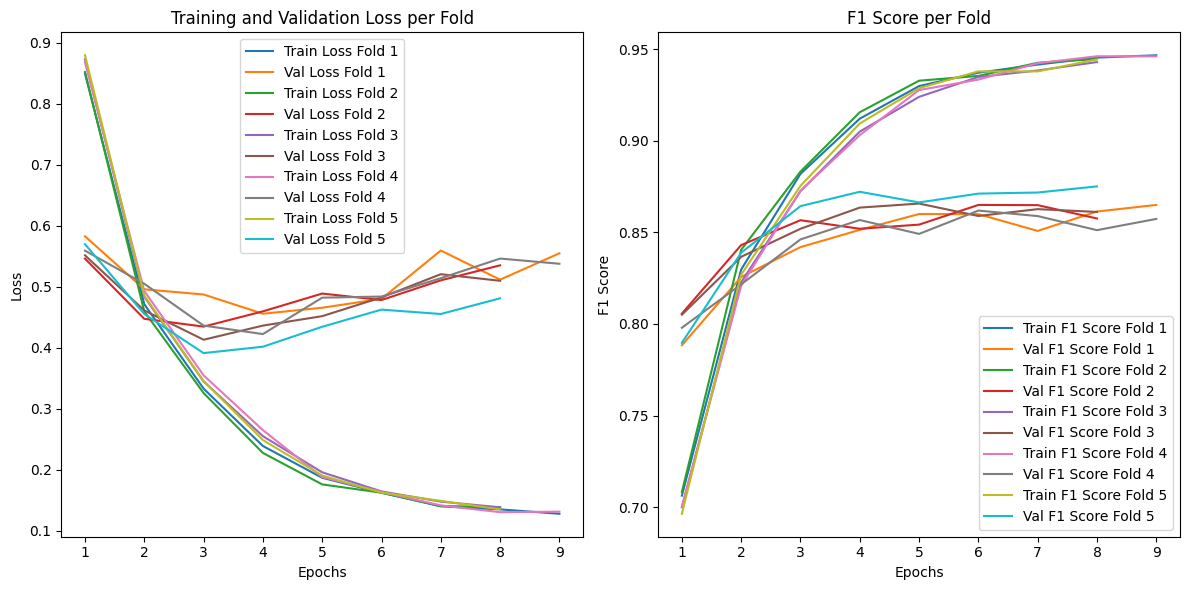

In [11]:
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from transformers import AdamW, AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import f1_score, classification_report
from tqdm import tqdm
import pandas as pd

# 설정
k = 5  # K-Fold 교차 검증에서의 fold 수
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# 모델 및 토크나이저 설정
model_name = "microsoft/graphcodebert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 전체 데이터셋을 준비
total_df = pd.read_csv("/content/drive/MyDrive/Labels_Safe_MSR+Juliet_random.csv")

# 결과를 저장할 리스트
all_train_losses = []
all_val_losses = []
all_train_f1_scores = []
all_val_f1_scores = []

# 각 fold에 대한 훈련 시작
fold = 0
for train_index, val_index in kf.split(total_df):
    fold += 1
    train_data = total_df.iloc[train_index]
    val_data = total_df.iloc[val_index]

    train_dataset = CodeDataset(tokenizer, train_data, max_length=512)
    val_dataset = CodeDataset(tokenizer, val_data, max_length=512)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

    # 모델 재설정 (각 fold에서 새로운 모델을 사용)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=11)
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=2e-5)

    train_losses = []
    val_losses = []
    train_f1_scores = []
    val_f1_scores = []

    # 얼리스탑 설정
    patience = 5
    best_val_loss = float('inf')
    early_stopping_counter = 0
    early_stopping_threshold = 0.01  # 최소 변화량

    for epoch in range(100):  # 에폭 수 변경 가능
        model.train()
        total_train_loss = 0
        all_predictions_train = []
        all_labels_train = []
        for batch in tqdm(train_loader):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            total_train_loss += loss.item()

            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            labels = batch["labels"]

            all_predictions_train.extend(predictions.cpu().numpy())
            all_labels_train.extend(labels.cpu().numpy())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss = total_train_loss / len(train_loader)
        train_f1 = f1_score(all_labels_train, all_predictions_train, average='weighted')

        model.eval()
        total_val_loss = 0
        all_predictions_val = []
        all_labels_val = []
        for batch in tqdm(val_loader):
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = model(**batch)
            loss = outputs.loss
            total_val_loss += loss.item()

            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            labels = batch["labels"]

            all_predictions_val.extend(predictions.cpu().numpy())
            all_labels_val.extend(labels.cpu().numpy())

        val_loss = total_val_loss / len(val_loader)
        val_f1 = f1_score(all_labels_val, all_predictions_val, average='weighted')

        # 클래스별 F1-score 계산
        class_report = classification_report(all_labels_val, all_predictions_val, digits=4, output_dict=False)
        print(f"Fold {fold}, Epoch {epoch+1}, Training Loss: {train_loss}, Train F1 Score: {train_f1}, Validation Loss: {val_loss}, Validation F1 Score: {val_f1}")
        print("Classification Report:")
        print(class_report)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_f1_scores.append(train_f1)
        val_f1_scores.append(val_f1)

        # 얼리스탑 로직
        if val_loss < best_val_loss - early_stopping_threshold:
            best_val_loss = val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1} for fold {fold}")
                break

    # 폴드 결과를 저장
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_train_f1_scores.append(train_f1_scores)
    all_val_f1_scores.append(val_f1_scores)

# 그래프로 나타내기
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for i in range(k):
    plt.plot(range(1, len(all_train_losses[i]) + 1), all_train_losses[i], label=f'Train Loss Fold {i+1}')
    plt.plot(range(1, len(all_val_losses[i]) + 1), all_val_losses[i], label=f'Val Loss Fold {i+1}')
plt.title('Training and Validation Loss per Fold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
for i in range(k):
    plt.plot(range(1, len(all_train_f1_scores[i]) + 1), all_train_f1_scores[i], label=f'Train F1 Score Fold {i+1}')
    plt.plot(range(1, len(all_val_f1_scores[i]) + 1), all_val_f1_scores[i], label=f'Val F1 Score Fold {i+1}')
plt.title('F1 Score per Fold')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()


In [12]:
# 검증 세트를 이용한 모델 평가
model.eval()
total_eval_accuracy = 0
for batch in tqdm(val_loader):
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    labels = batch["labels"]

    # 정확도 계산
    accuracy = (predictions == labels).cpu().numpy().mean() * 100
    total_eval_accuracy += accuracy

# 에폭당 평균 검증 정확도 계산
avg_val_accuracy = total_eval_accuracy / len(val_loader)
print(f"Validation Accuracy: {avg_val_accuracy:.2f}%")

100%|██████████| 205/205 [00:39<00:00,  5.24it/s]

Validation Accuracy: 87.59%
